In [31]:
# compare ensemble free energies with ViennaRNA
import random

import jax.numpy as jnp

import ViennaRNA as RNA
from shapetune import _partition

# generate 5000 random sequences between 100 and 200 nt
random.seed(2)
sequences = [''.join(random.choice("ACGU") for _ in range(random.randint(100, 200))) for _ in range(5000)]
seqarrs = [jnp.frombuffer(seq.encode().translate(_partition.CONSTANTS.TRANSLATER), dtype=jnp.uint8) for seq in sequences]

In [ ]:
# register PartitionVal with jax
from jax.tree_util import register_pytree_node

register_pytree_node(
    _partition.PartitionVal, _partition.PartitionVal._tree_flatten, _partition.PartitionVal._tree_unflatten
)

In [54]:
import tqdm

# find partition of ViennaRNA
def turner_efe(seq):
    fc = RNA.fold_compound(seq)
    return fc.pf()[1]

vienna_efe = [turner_efe(seq) for seq in tqdm.tqdm(sequences)]

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [02:14<00:00, 37.26it/s]


In [82]:
import jax

@jax.jit
def shapetune_efe(seqarr):
    return _partition._partition_arr(seqarr, _partition.CONSTANTS.STACKING_PAIRS).efe()

cannon_efes = [shapetune_efe(seqarr) for seqarr in tqdm.tqdm(seqarrs)]
cannon_efes = [efe.item() for efe in cannon_efes]

100%|██████████| 5000/5000 [00:29<00:00, 171.66it/s]


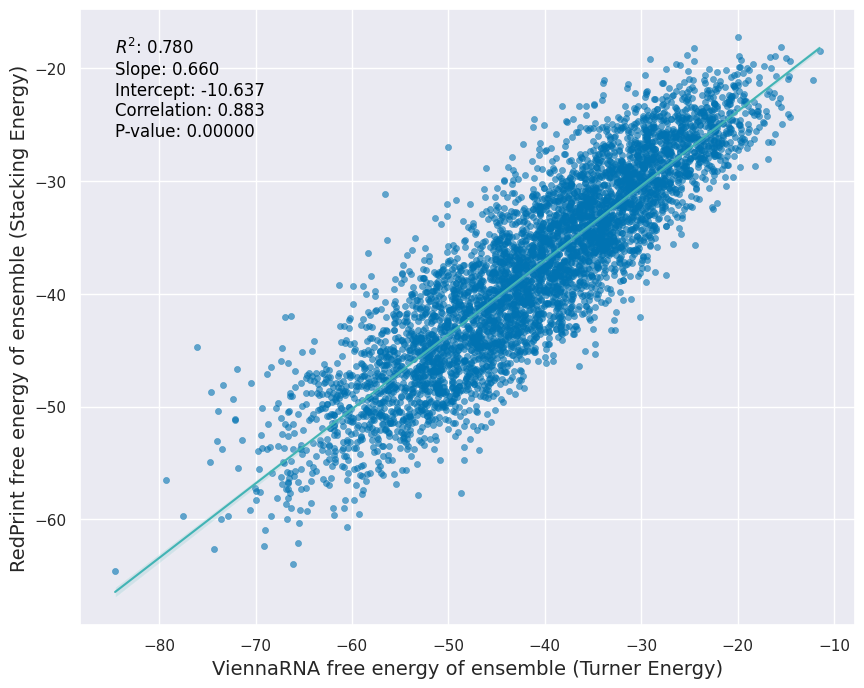

Linear Relationship: y = 0.660x + -10.637
R^2: 0.780
Correlation Coefficient: 0.883
P-value: 0.0000000000


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Set plot aesthetics
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")

# Scatter plot with improved aesthetics
plt.figure(figsize=(10, 8))
sns.scatterplot(x=vienna_efe, y=cannon_efes, s=20, alpha=0.6, edgecolor=None)

# Regression line
sns.regplot(
    x=vienna_efe,
    y=cannon_efes,
    scatter=False,
    color="#42b4b5",
    line_kws={"linewidth": 1.5},
)

# Calculate linear regression statistics
slope, intercept, r_value, p_value, std_err = linregress(vienna_efe, cannon_efes)

# Adding R-squared value to the plot
plt.text(
    x=min(vienna_efe),
    y=max(cannon_efes),
    s=f"$R^2$: {r_value**2:.3f}\nSlope: {slope:.3f}\nIntercept: {intercept:.3f} \nCorrelation: {r_value:.3f}\nP-value: {p_value:.5f}",
    ha="left",
    va="top",
    fontsize=12,
    color="black",
)

# Axis labels
plt.xlabel("ViennaRNA free energy of ensemble (Turner Energy)", fontsize=14)
plt.ylabel("RedPrint free energy of ensemble (Stacking Energy)", fontsize=14)

# Show plot
plt.show()

# Print out regression results
print(f"Linear Relationship: y = {slope:.3f}x + {intercept:.3f}")
print(f"R^2: {r_value**2:.3f}")
print(f"Correlation Coefficient: {r_value:.3f}")
print(f"P-value: {p_value:.10f}")